In [ ]:

from google.colab import drive
drive.mount("/OCR")


Mounted at /OCR


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import cv2
import os
import imutils
from google.colab.patches import cv2_imshow
import pickle
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import datetime
import platform


In [ ]:
!pip install easyocr


In [ ]:
import easyocr
reader = easyocr.Reader(['en'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.0/646.0 kB 5.4 MB/s eta 0:00:00


In [ ]:

from ultralytics import YOLO

# Load a model
model = YOLO('https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8x-pose-p6.pt')


100%|██████████| 190M/190M [00:01<00:00, 150MB/s]


In [ ]:
img=cv2.imread('/OCR/MyDrive/EasyOCR/3.jpg')
r=model.predict(img, save=False, imgsz=1280, conf=0.5)
j_r=r[0].tojson()


0: 704x1280 3 persons, 11721.4ms
Speed: 45.4ms preprocess, 11721.4ms inference, 1.6ms postprocess per image at shape (1, 3, 704, 1280)



0: 896x1280 3 persons, 14062.1ms
Speed: 13.4ms preprocess, 14062.1ms inference, 1.7ms postprocess per image at shape (1, 3, 896, 1280)


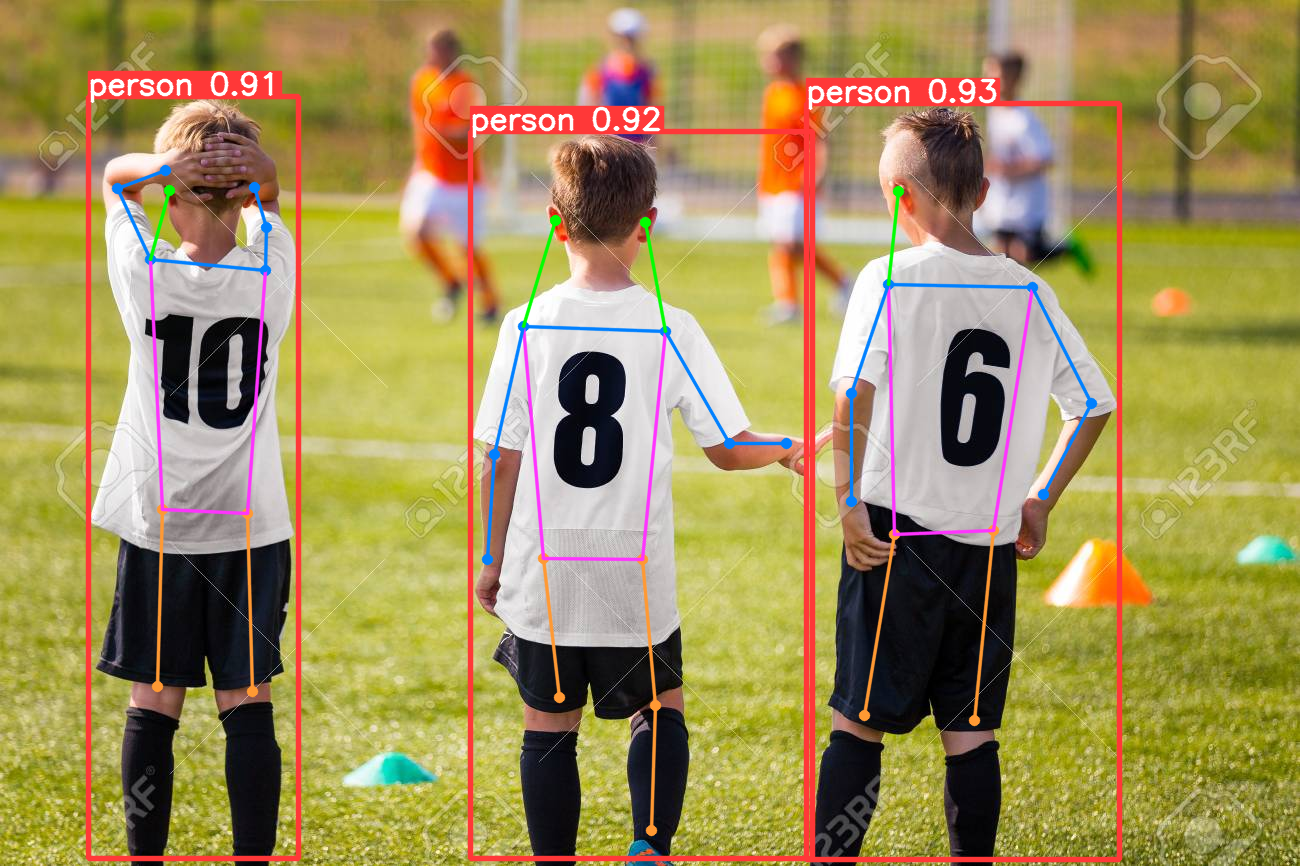

In [ ]:

img=cv2.imread('/OCR/MyDrive/EasyOCR/3_.jpg')
r=model.predict(img, save=False, imgsz=1280, conf=0.90)
a_f=r[0].plot()

cv2_imshow(a_f)

In [ ]:

def find_polygon(image_path):
  result = model.predict(image_path,imgsz=1280, conf=0.7)[0]
  print("asd : ",len(result.keypoints.data))
  vertices_all=[]
  for k in range(len(result.keypoints.data)):
    # print("iiiiiiiiiiiiiiiiii : ",k)
    keypoints = result.keypoints.data[k].tolist()
    # print(len(keypoints))
    for i, kp in enumerate(keypoints):
        x = int(kp[0])
        y = int(kp[1])
        if(i==5):
          left_shoulder=(x,y)
        if(i==6):
          right_shoulder=(x,y)
        if(i==11):
          left_hip=(x,y)
        if(i==12):
          right_hip=(x,y)
    # Define 4 points of the polygon (clockwise or counterclockwise order)
    v_tmp = np.array([left_shoulder,right_shoulder,right_hip,left_hip], dtype=np.int32)
    vertices_all.append(v_tmp)
    # print("x : ",x,"     y: ",y,"    visibility : ",int(kp[2]))
  return vertices_all

# vertices=find_polygon("/OCR/MyDrive/EasyOCR/3_.jpg")
# vertices


image 1/1 /OCR/MyDrive/EasyOCR/3_.jpg: 896x1280 7 persons, 17037.6ms
Speed: 25.9ms preprocess, 17037.6ms inference, 1.8ms postprocess per image at shape (1, 3, 896, 1280)
asd :  7


In [ ]:

def polygon_to_bbox(polygons):
    bbox_all=[]
    for polygon in polygons:
      x_coordinates = [point[0] for point in polygon]
      y_coordinates = [point[1] for point in polygon]

      xmin = min(x_coordinates)
      ymin = min(y_coordinates)
      xmax = max(x_coordinates)
      ymax = max(y_coordinates)

      width = xmax - xmin
      height = ymax - ymin
      bbox_all.append((xmin, ymin, width, height))

    return bbox_all

# bbox=polygon_to_bbox(vertices)
# bbox

[(888, 284, 144, 250), (523, 326, 142, 233), (150, 259, 115, 254)]

In [ ]:

def perform_ocr_on_image(img, coordinates_all):
    text_label=[]
    for coordinates in coordinates_all:
      print(coordinates)
      x=coordinates[0]
      y=coordinates[1]
      w=coordinates[2]
      h=coordinates[3]
      # print(x,y,w,h)
      cropped_img = img[y:y+h, x:x+w]

      # print(cropped_img)
      gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
      results = reader.readtext(gray_img)
      # print("sdsdds",results)
      text = ""
      for res in results:
          if len(results) == 1 or (len(res[1]) > 6 and res[2] > 0.2):
              text = res[1]
      text_label.append(str(text))
    return text_label

# image_path = '/OCR/MyDrive/EasyOCR/3_.jpg'
# image = cv2.imread(image_path)
# ocr_results = perform_ocr_on_image(image, bbox)
# ocr_results

(888, 284, 144, 250)
(523, 326, 142, 233)
(150, 259, 115, 254)


['6', '8', '10']

In [ ]:

def display_ocr_results(image, bounding_boxes, ocr_results):
    # Draw bounding boxes around keypoints
    print("display_ocr_results : ",ocr_results)
    for bbox in bounding_boxes:
        xmin, ymin, width, height = bbox
        cv2.rectangle(image, (xmin, ymin), (xmin + width, ymin + height), (0, 255, 0), 2)

    # Display OCR results on the image
    for i, (result, bbox) in enumerate(zip(ocr_results, bounding_boxes)):
        xmin, ymin, _, _ = bbox
        cv2.putText(image, f"{result}", (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0,255), 2, cv2.LINE_AA)

    # Display the image
    cv2_imshow( image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
a=['', '21']
for i in range(len(a)):
  if(len(a[i])==0):
    a[i]="Need Face"
a

['Need Face', '21']


image 1/1 /OCR/MyDrive/Number-Plate-Recognition/frame_0003.jpeg: 768x1280 3 persons, 12876.0ms
Speed: 6.8ms preprocess, 12876.0ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1280)
asd :  3
(499, 272, 18, 106)
(650, 241, 97, 141)
(418, 308, 25, 84)
display_ocr_results :  ['Face', '21', 'Face']


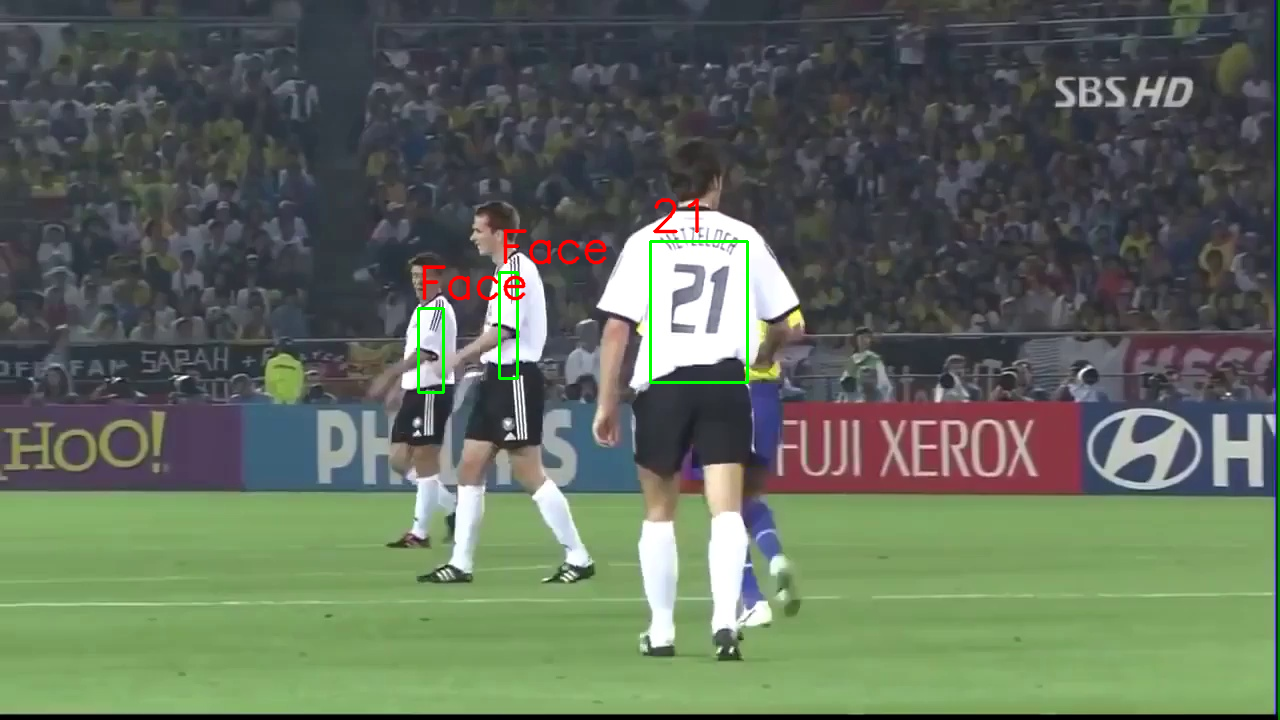

In [ ]:


# Replace 'your_image_path.jpg' with the path to your image file
image_path = '/OCR/MyDrive/Number-Plate-Recognition/frame_0003.jpeg'

vertices=find_polygon(image_path)

bbox=[]
bbox.append(polygon_to_bbox(vertices))

# Load the image for OCR
image = cv2.imread(image_path)
# Perform OCR on the regions defined by keypoints
ocr_results = perform_ocr_on_image(image, bbox[0])
# print(ocr_results)
for i in range(len(ocr_results)):
  if(len(ocr_results[i])==0):
    ocr_results[i]="Face"

if(len(ocr_results)==0):
  print("please go to face detection")
else:
  # Display OCR results on the image
  display_ocr_results(image, bbox[0], list(ocr_results))



image 1/1 /OCR/MyDrive/EasyOCR/3_.jpg: 896x1280 3 persons, 14260.8ms
Speed: 26.0ms preprocess, 14260.8ms inference, 2.2ms postprocess per image at shape (1, 3, 896, 1280)
asd :  3
(888, 284, 144, 250)
(523, 326, 142, 233)
(150, 259, 115, 254)
display_ocr_results :  ['6', '8', '10']


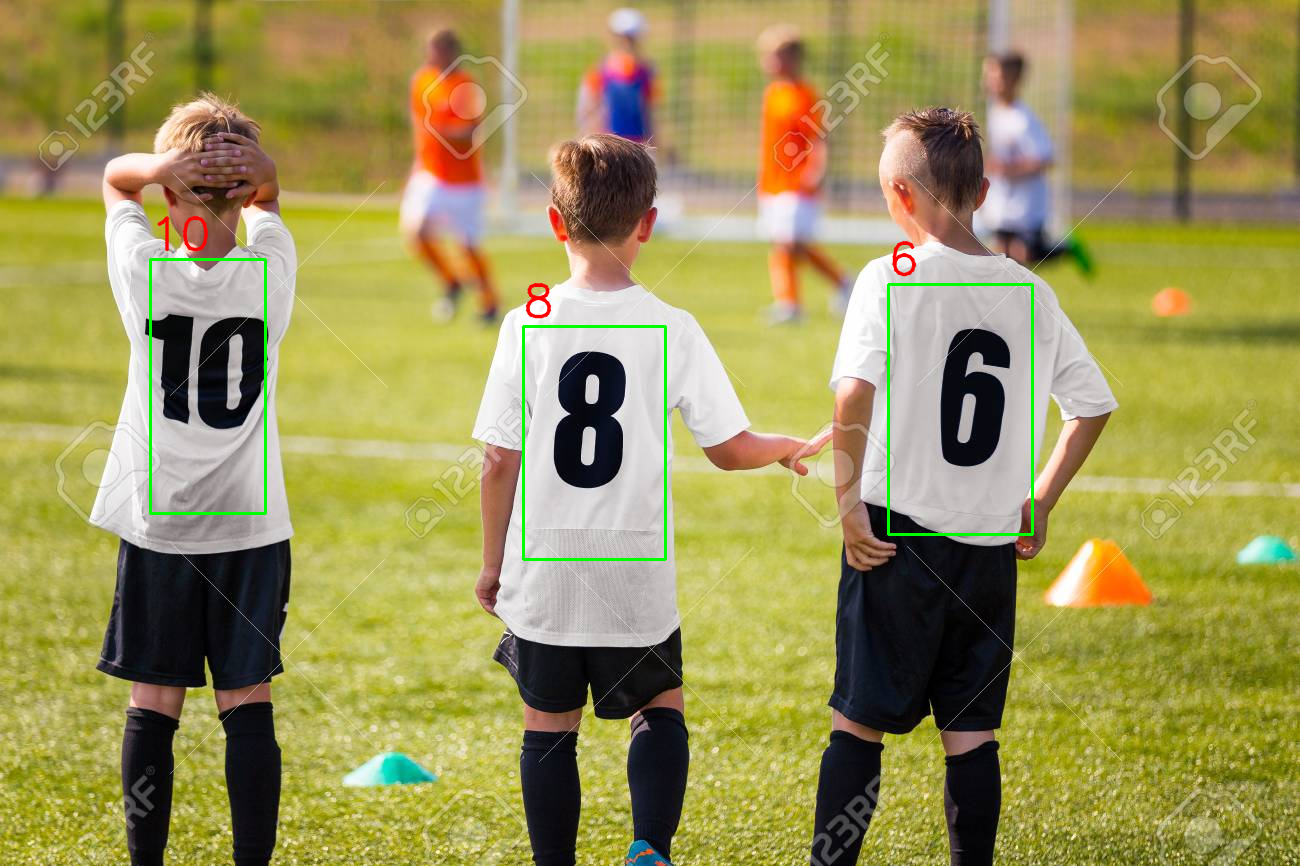

In [ ]:


# Replace 'your_image_path.jpg' with the path to your image file
image_path = '/OCR/MyDrive/EasyOCR/3_.jpg'

vertices=find_polygon(image_path)

bbox=[]
bbox.append(polygon_to_bbox(vertices))

# Load the image for OCR
image = cv2.imread(image_path)
# Perform OCR on the regions defined by keypoints
ocr_results = perform_ocr_on_image(image, bbox[0])
# print(ocr_results)

if(len(ocr_results)==0):
  print("please go to face detection")
else:
  # Display OCR results on the image
  display_ocr_results(image, bbox[0], list(ocr_results))


In [ ]:


# Replace 'your_image_path.jpg' with the path to your image file
image_path = '/OCR/MyDrive/EasyOCR/images.jpg'

vertices=find_polygon(image_path)

bbox=[]
bbox.append(polygon_to_bbox(vertices))

# Load the image for OCR
image = cv2.imread(image_path)
# Perform OCR on the regions defined by keypoints
ocr_results = perform_ocr_on_image(image, bbox[0])
# print(ocr_results)

if(len(ocr_results)==0):
  print("please go to face detection")
else:
  # Display OCR results on the image
  display_ocr_results(image, bbox[0], list(ocr_results))
